In [4]:
# --- Imports ---
import os
import sys

# Chemin vers le dossier contenant utils.py
sys.path.append(os.path.abspath(".."))
from utils import (
    # execute_model,
    save_results,
    calculate_scores,
    ThresholdedClassifier,
    # save_and_compare_grid_result
)

import pandas as pd
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    recall_score, make_scorer, accuracy_score, classification_report,
    precision_recall_curve, ConfusionMatrixDisplay, roc_auc_score, precision_score, f1_score
)
from sklearn.model_selection import train_test_split, GridSearchCV
# import joblib
import matplotlib.pyplot as plt


# --- Chargement des données ---
DF_PATH = "../data/balanced_3.csv"
df = pd.read_csv(DF_PATH, sep=";", index_col="id")

# --- Séparation features / cible ---
X = df.drop(columns=["cardio"])
y = df["cardio"]

# --- Calcul poids manuel pour déséquilibre ---
counter = Counter(y)
n0, n1 = counter[0], counter[1]
manual_weight = {0: 1, 1: round(n0 / n1, 2)}
print("Poids manuel calculé :", manual_weight)

# --- Création d'un scorer personnalisé (recall classe 1) ---
recall_scorer = make_scorer(recall_score, pos_label=1)

# --- Définition modèle de base ---
model = LogisticRegression()

# --- Split train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


ValueError: Index id invalid

In [ ]:
df.index

RangeIndex(start=0, stop=15808, step=1)

In [4]:

# --- Grille d'hyperparamètres pour GridSearchCV ---
param_grid = [
#     {
#     'penalty': ['elasticnet'],
#     'solver': ['saga'],
#     'C': [28, 29],
#     'l1_ratio': [0.47, 0.49],
#     'class_weight': ['balanced', manual_weight],
#     'max_iter': [1000]
# }
    {
    'penalty': ['elasticnet'],
    'solver': ['saga'],
    'C': [10, 20],
    'l1_ratio': [0.2, 0.3, 0.4],
    'class_weight': ['balanced', manual_weight],
    'max_iter': [1000]
}
]

# --- Chemin du fichier résultat + dossier modèles ---
RESULTS_CSV = "results.csv"
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)
# --- Chargement du meilleur modèle depuis résultats existants ---
from utils import load_best_model_from_results


best_model_grid = None
if os.path.exists(RESULTS_CSV):
    best_model_grid = load_best_model_from_results(RESULTS_CSV, MODEL_DIR)

# --- Si aucun modèle existant ou pas optimal, relancer une recherche ---
if best_model_grid is None:
    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=5,
        scoring=recall_scorer,
        n_jobs=-1,
        verbose=2
    )
    grid_search.fit(X_train, y_train)
    best_model_grid = grid_search.best_estimator_
    print("✅ Grid search terminée.")

    # --- Seuil optimal ---
    y_proba = best_model_grid.predict_proba(X_test)[:, 1]
    best_threshold = find_best_threshold_for_recall(y_test, y_proba)
    final_model = ThresholdedClassifier(model=best_model_grid, threshold=best_threshold)
    y_pred = final_model.predict(X_test)
    y_proba_full = final_model.predict_proba(X_test)

    # --- Calcul des scores
    scores = calculate_scores(y_test, y_pred, y_proba=y_proba_full[:, 1], prefix="metric_")
    scores["threshold"] = best_threshold

    # --- Sauvegarde et comparaison
    from utils import save_and_compare_grid_result
    best_params, best_scores = save_and_compare_grid_result(
        model=best_model_grid,
        params=grid_search.best_params_,
        scores=scores,
        result_file=RESULTS_CSV,
        model_dir=MODEL_DIR
    )

    print("📊 Nouveau modèle évalué et comparé aux précédents.")
else:
    print("📦 Meilleur modèle existant chargé depuis les résultats.")

# --- Utilisation finale ---
final_model = ThresholdedClassifier(model=best_model_grid, threshold=scores.get("threshold", 0.5))
y_pred = final_model.predict(X_test)

print(classification_report(y_test, y_pred))




# # --- GridSearchCV ---
# MODEL_PATH = "best_model_logreg.joblib"

# if os.path.exists(MODEL_PATH):
#     best_model_grid = joblib.load(MODEL_PATH)
#     print("📦 Modèle chargé depuis le disque.")
# else:
#     grid_search = GridSearchCV(
#         model, param_grid,
#         cv=5,
#         scoring=recall_scorer,
#         n_jobs=-1,
#         verbose=2
#     )
#     grid_search.fit(X_train, y_train)
#     best_model_grid = grid_search.best_estimator_
#     print("✅ Grid search terminée.")

#     # Évaluer ce modèle avec seuil
#     y_proba = best_model_grid.predict_proba(X_test)[:, 1]
#     best_threshold = find_best_threshold_for_recall(y_test, y_proba)
#     final_model = ThresholdedClassifier(model=best_model_grid, threshold=best_threshold)
#     y_pred = final_model.predict(X_test)
#     y_proba_full = final_model.predict_proba(X_test)

#     # Calcul des scores
#     scores = calculate_scores(y_test, y_pred, y_proba=y_proba_full[:, 1], prefix="metric_")
#     scores["threshold"] = best_threshold

#     # Sauvegarde + comparaison avec anciens résultats
#     best_params, best_scores = save_and_compare_grid_result(
#         model=best_model_grid,
#         params=grid_search.best_params_,
#         scores=scores,
#         result_file="results.csv",
#         model_dir="models"
#     )






Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\coule\Documents\projets\cardio-vasc-risks\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Grid search terminée.


NameError: name 'find_best_threshold_for_recall' is not defined

In [17]:

# --- Obtenir les probabilités sur le test set ---
y_proba = best_model_grid.predict_proba(X_test)[:, 1]

# --- Fonction pour trouver le meilleur seuil maximisant le recall ---
def find_best_threshold_for_recall(y_true, y_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    best_index = recall.argmax()
    best_threshold = thresholds[best_index - 1] if best_index > 0 else 0.5
    print(f"🔍 Meilleur seuil trouvé : {best_threshold:.4f} avec recall = {recall[best_index]:.4f}")
    return best_threshold, precision, recall, thresholds

best_threshold, precision, recall, thresholds = find_best_threshold_for_recall(y_test, y_proba)


🔍 Meilleur seuil trouvé : 0.5000 avec recall = 1.0000


In [18]:

# --- Modèle avec seuil personnalisé ---
final_model = ThresholdedClassifier(model=best_model_grid, threshold=best_threshold)

# --- Prédictions avec seuil personnalisé ---
y_pred = final_model.predict(X_test)
y_proba_full = final_model.predict_proba(X_test)

# --- Calcul des scores ---
scores = calculate_scores(y_test, y_pred, y_proba=y_proba_full[:, 1], prefix="metric_")
scores["threshold"] = best_threshold

print("Scores calculés :", scores)

# --- Enregistrement des résultats ---
save_results(
    model=best_model_grid,
    scores=scores,
    data_path=DF_PATH,
    output_path="../results_2.csv"
)


Scores calculés : {'metric_Accuracy': 0.6157495256166983, 'metric_Precision': 0.6280838723101732, 'metric_Recall': 0.6182454456720228, 'metric_Recall_1': 0.759175788795879, 'metric_F1_Score': 0.6091460215520439, 'metric_roc_auc': np.float64(0.6794343792983526), 'metric_average_precision': np.float64(0.6558846282041986), 'threshold': 0.5}
✅ Résultat enregistré dans ../results_2.csv


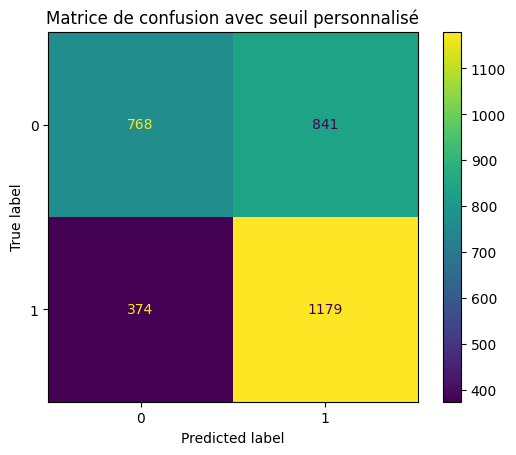

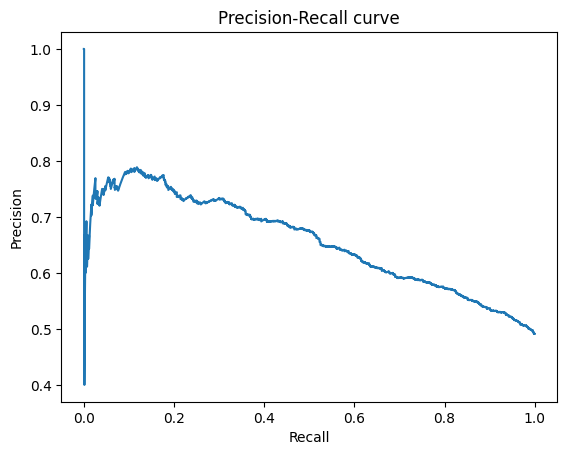

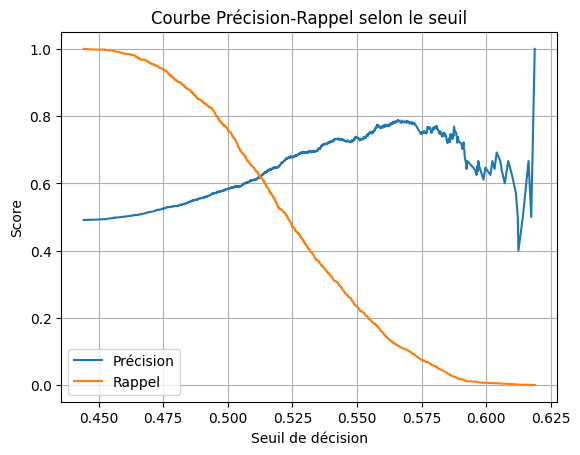

              precision    recall  f1-score   support

           0       0.67      0.48      0.56      1609
           1       0.58      0.76      0.66      1553

    accuracy                           0.62      3162
   macro avg       0.63      0.62      0.61      3162
weighted avg       0.63      0.62      0.61      3162

Accuracy: 0.6157
Precision: 0.5837
Recall: 0.7592
F1-score: 0.6599


In [19]:

# --- Affichage matrice de confusion ---
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Matrice de confusion avec seuil personnalisé")
plt.show()

# --- Courbe Precision-Recall ---
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()

# --- Courbes Précision et Rappel selon le seuil ---
plt.plot(thresholds, precision[:-1], label='Précision')
plt.plot(thresholds, recall[:-1], label='Rappel')
plt.xlabel('Seuil de décision')
plt.ylabel('Score')
plt.legend()
plt.title('Courbe Précision-Rappel selon le seuil')
plt.grid()
plt.show()

# --- Rapport détaillé ---
print(classification_report(y_test, y_pred))

# --- Affichage des métriques principales ---
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision_val = precision_score(y_test, y_pred)
recall_val = recall_score(y_test, y_pred)
f1_val = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"Recall: {recall_val:.4f}")
print(f"F1-score: {f1_val:.4f}")
